# Authors
- Clarissa Harmoko
- Kai Ze Tam
- Kyle Carlo Lasala
- Muhammad Abdul Aziz Ghazali

# PART I: Molecular Docking + VQE Workflow

**NOTE: Currently, the Variational Quantum Eigensolver (VQE) cannot be reliably used to compute the total energy of realistic protein-ligand systems due to scalability limitations.**

Due to current hardware limitations, VQE cannot yet be applied to compute the total energy of full protein-ligand systems.

To make the problem tractable on today’s quantum devices, we simplify the system—sometimes down to just a few atoms. For instance, selecting only three atoms (1 atom from the ligand, 2 atoms from the protein) allows VQE to run, but this is a drastic simplification that fails to capture the full electronic structure of the system. As such, this is not intended to provide chemically accurate results but instead serves as a proof of concept for the workflow. 

**The goal is to demonstrate how quantum algorithms could eventually be integrated into molecular simulations once quantum hardware becomes more scalable.**

## Prepare Libraries

Download the necessary libraries

In [1]:
!conda install -c conda-forge numpy swig boost-cpp libboost sphinx sphinx_rtd_theme -y
!pip install vina
!conda install -c conda-forge mdanalysis -y
!pip install rdkit
!pip install prolif
!conda install nglview -c conda-forge -y
!pip install pdb2pqr
# !pip install meeko
!pip install biopython
!pip install gemmi
!pip install py3Dmol
!pip install --prefer-binary pyscf
!pip install qiskit==1.4.3
!pip install qiskit-nature
!pip install qiskit-aer

                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


Import the installed libraries

In [52]:
import os
import requests
import numpy as np
import pandas as pd
import warnings
from Bio.PDB import PDBList, PDBParser, Select, PDBIO
import MDAnalysis as mda
import nglview as nv
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolfiles
from vina import Vina
import prolif as plf
from meeko import PDBQTMolecule, RDKitMolCreate
from pyscf import gto, scf, dft
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit_aer import Aer

Create the folders for the protein files and ligand files

In [3]:
protein_folder = 'protein/'
ligand_folder = 'ligand/'

os.makedirs(protein_folder, exist_ok=True)
os.makedirs(ligand_folder, exist_ok=True)

## Protein Preparation

The target is the NS3 RNA helicase (a viral protein/enzyme) of Dengue virus serotype 2 (DENV2). This helicase unwinds double-stranded RNA (dsRNA) intermediates into single-stranded RNA (ssRNA), a critical step in the replication of the viral genome.

In [4]:
protein_id = "2BMF"# This is the ID of the NS3 RNA helicase

pdb_request = requests.get(f"https://files.rcsb.org/download/{protein_id}.pdb")
if pdb_request.status_code == 200:
    with open(f"{protein_folder}/{protein_id}.pdb", "w+") as f:
        f.write(pdb_request.text)
else: raise Exception("Fetch error")

NS3 RNA Helicase Visualization

In [5]:
u = mda.Universe(f"{protein_folder}{protein_id}.pdb")
nv.show_mdanalysis(u)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

Select the first segment of the protein since there are 2 segments. In the cell below, we also visualize the protein's surface area colored by hydrophobicity. Waters from the crystal structure are in spacefill representation, and we add the ligand in a ball and stick representation.

In [6]:
protein = u.select_atoms("protein and segid A")
water = u.select_atoms("resname HOH and segid A")
view = nv.show_mdanalysis(protein)
view.clear_representations()
view.add_representation('surface', colorScheme="hydrophobicity")
water_view = nv.show_mdanalysis(water)
water_view.add_representation('spacefill')
view

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

Save the selected chain.

In [7]:
protein.write(f"{protein_folder}protein_{protein_id}.pdb")

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


We want to ensure that we've correctly added hydrogen and fixed any missing atoms.

For fixing our protein, we will use a specialized program called PDB2PQR that is made for working with biomolecules like proteins. The advantage of using PDB2PQR is that it will check our protein for missing atoms and multiple occupancy in the protein, and it will pick positions and add missing atoms.

In [8]:
!pdb2pqr --pdb-output="{protein_folder}protein_h.pdb" --pH=7.4 "{protein_folder}protein_{protein_id}.pdb" "{protein_folder}protein_{protein_id}.pqr" --whitespace

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=5026) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein/protein_2BMF.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     2>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 442 residues and 3531 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 24 missing atoms in biomolecule.
INFO:Added atom CG to residue LYS A 199 at coordinat

In [9]:
u = mda.Universe(f"{protein_folder}protein_{protein_id}.pqr")
u.atoms.write(f"{protein_folder}{protein_id}.pdbqt")

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/MDAnalysis/coordinates/PDBQT.py:305: UserWarning: Supplied AtomGroup was missing the following attributes: altLocs, occupancies, tempfactors. These will be written with default values. 
  warnings.warn(


In [10]:
# Read in the just-written PDBQT file, replace text, and write back
with open(f"{protein_folder}{protein_id}.pdbqt", 'r') as file:
    file_content = file.read()

# Replace 'TITLE' and 'CRYST1' with 'REMARK'
file_content = file_content.replace('TITLE', 'REMARK').replace('CRYST1', 'REMARK')

# Write the modified content back to the file
with open(f"{protein_folder}{protein_id}.pdbqt", 'w') as file:
    file.write(file_content)

## Ligand Preparation

The ligand selected is based on the study of Halim et al. [1]. The ligand with the highest Chemgauss2 (CG2) score is selected. The Simplified Molecular Input Line Entry System (SMILES) format of the selected ligand is `CCCSc1ncc(c(n1)C(=O)Nc2nc3ccc(cc3s2)OC)Cl`. This will be used to benchmark the tools.

[1] S. A. Halim, S. Khan, A. Khan, A. Wadood, F. Mabood, J. Hussain, and A. Al-Harrasi, “Targeting Dengue Virus NS-3 Helicase by Ligand based Pharmacophore Modeling and Structure based Virtual Screening,” Frontiers in Chemistry, vol. 5, p. 88, 2017. [Online]. Available: https://doi.org/10.3389/fchem.2017.00088

In [11]:
smiles = "CCCSc1ncc(c(n1)C(=O)Nc2nc3ccc(cc3s2)OC)Cl"

mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.UFFOptimizeMolecule(mol)

writer = rdmolfiles.PDBWriter(f"{ligand_folder}ligand.pdb")
writer.write(mol)
writer.close()

Chem.MolToMolFile(mol, f"{ligand_folder}ligand.mol")

Compound visualization

In [12]:
u = mda.Universe(f"{ligand_folder}ligand.pdb")
nv.show_mdanalysis(u)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

Use meeko to prepare small molecules - using meeko helps us visualize them later.

In [13]:
!mk_prepare_ligand.py -i "{ligand_folder}ligand.mol" -o "{ligand_folder}prepared_ligand.pdbqt"

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=5026) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


## Pre-Docking: Defining the Search Box

When we dock our ligands to our protein, we will want to define the binding pocket. To define our binding box, we will take the position of the significant molecular interactions between the DENV and the said compound according to the study of Halim et al. [1]. Halim et al. mentioned the residue LYS388 and ARG599.

[1] S. A. Halim, S. Khan, A. Khan, A. Wadood, F. Mabood, J. Hussain, and A. Al-Harrasi, “Targeting Dengue Virus NS-3 Helicase by Ligand based Pharmacophore Modeling and Structure based Virtual Screening,” Frontiers in Chemistry, vol. 5, p. 88, 2017. [Online]. Available: https://doi.org/10.3389/fchem.2017.00088

The cell below selects and visualizes the LYS388.

In [14]:
u = mda.Universe(f"{protein_folder}protein_{protein_id}.pdb")
res1 = u.select_atoms("resid 388")
nv.show_mdanalysis(res1)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

The cell below selects and visualizes the ARG599.

In [15]:
res2 = u.select_atoms("resid 599")
nv.show_mdanalysis(res2)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

Based on the coordinates of LYS388 and ARG599, we compute the center of the search box and define the size. To be sure, we add a padding of 10 angstrom.

In [16]:
cg1 = res1.center_of_geometry()
cg2 = res2.center_of_geometry()
coors = np.vstack([cg1, cg2])
center = coors.sum(axis=0) / 2
center = center.tolist()
ligand_box = coors.max(axis=0) - coors.min(axis=0) + 10 # padding of 10
ligand_box = ligand_box.tolist()
print("center:", center)
print("box:", ligand_box)

center: [-4.630055514756929, -3.6067424138086013, 55.17953026896775]
box: [13.110111062160946, 20.84615146180596, 10.402394651162503]


## Docking Ligands with AutoDock Vina

We generated the PDBQT version of the ligand and protein from the previous steps. We also defined our docking box. Now, we are ready to perform the actual docking using AutoDock Vina.

Before docking, we will make a directory to store our results and initialize the Vina object. 

We will dock using the AutoDock Vina Python API. We start docking with the line `v = Vina(sf_name="vina")` This creates a docking calculation, v, and sets the scoring function to the vina scoring function

In [17]:
os.makedirs("docking_results", exist_ok=True)
v = Vina(sf_name="vina", seed=1695247494) # seed is set for consistency

We setup the protein as the receptor and prepare the ligand.

In [18]:
v.set_receptor(f"{protein_folder}{protein_id}.pdbqt")
v.set_ligand_from_file(f"{ligand_folder}prepared_ligand.pdbqt")
v.compute_vina_maps(center=center, box_size=ligand_box)

Computing Vina grid ... done.


There are two parameters to docking, the `exhaustiveness` and `n_poses`. The exhaustiveness parameter describes the "exhaustiveness" of the docking - a higher exhaustiveness means that more ligand conformations are tried. Exhaustiveness also corresponds to the amount of computational effort used during a docking experiment. The default exhaustiveness value is 8; increasing this to 32 will give a more consistent docking result.

In [19]:
v.dock(exhaustiveness=32, n_poses=10)

Performing docking (random seed: 1695247494) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


After the `dock` function, we can write the poses that were calculated to a file. Note that the output format from AutoDock Vina is a PDBQT file.

In [20]:
v.write_poses(f"docking_results/ligand-{protein_id}.pdbqt", n_poses=10, overwrite=True)

We can see the energies of the calculated poses by calling energies on the docking calculation variable. According to the Vina documentation, the rows correspond to the poses, while columns correspond to different energy types. The types of energies in the columns are `["total", "inter", "intra", "torsions", "intra best pose"]`.

In [21]:
column_names = ["total", "inter", "intra", "torsions", "intra best pose"]
df = pd.DataFrame(v.energies(), columns=column_names)
df.to_csv(f"docking_results/ligand-{protein_id}-energies.csv", index=False)
df

,total,inter,intra,torsions,intra best pose
0,-5.817,-7.857,-0.531,2.040,-0.531
1,-5.611,-7.785,-0.325,1.968,-0.531
2,-5.488,-7.354,-0.590,1.925,-0.531
3,-5.451,-7.811,-0.083,1.912,-0.531
4,-5.434,-7.391,-0.481,1.906,-0.531
5,-5.311,-7.467,-0.238,1.863,-0.531
6,-5.301,-7.545,-0.146,1.859,-0.531
7,-5.286,-7.027,-0.644,1.854,-0.531
8,-5.282,-7.142,-0.523,1.853,-0.531


## Visualizing Docking Results

After performing the docking simulation and saving the energies, you might wish to visualize the poses. When visualizing results from molecular docking, scientists often visually inspect the 3D docked structure as well as a 2D representation called an interaction map. We can ues a software called ProLIF (Protein-Ligand Interaction Fingerprints) to make and view these maps in the Jupyter notebook.

AutoDock Vina only writes in this file, but in order for us to visualize our results, we need a more standard format. We will use meeko again to convert our poses to an SDF. Note that meeko will only convert pdbqt files if it prepared the input docking files.

Again, we use a command line script to convert out poses.

In [22]:
!mk_export.py "docking_results/ligand-{protein_id}.pdbqt" -s "docking_results/ligand-{protein_id}.sdf"

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=5026) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


After converting to SDF, we can again visualize our results with ProLIF. ProLIF requires that molecules be loaded in and has functions to load molecules in several ways. We will use MDAnalysis for loading our proteins to ProLIF and `sdf_supplier` to load the SDFs we converted in the previous step.

In [23]:
protein = rdmolfiles.MolFromPDBFile(f"{protein_folder}protein_h.pdb")
protein_plf = plf.Molecule.from_rdkit(protein)
poses_plf = plf.sdf_supplier(f"docking_results/ligand-{protein_id}.sdf")

To analyze the interactions of the ligand and protein we create a molecular fingerprint object. By default, ProLIF will calculate nine types of interactions: 'Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact' However, you could set this to different interactions. 

In [24]:
fp = plf.Fingerprint(count=True)

Next, we will run ProLif on our poses. To do this calculation, we pass in our list of poses (`poses_plf`) and our ProLIF protein.

In [25]:
# run on your poses
fp.run_from_iterable(poses_plf, protein_plf)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/multiprocess/popen_fork.py:67: DeprecationWarning: This process (pid=5026) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/10 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7b7521e67cb0>

After running this analysis, we can visualize the interaction results. We are using the 2D and 3D visualization maps here.

In [26]:
pose_index=1
fp.plot_lignetwork(poses_plf[pose_index])

In [27]:
view = fp.plot_3d(
    poses_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Selecting the Binding Interaction

We will select the best pose and then check for the different interactions.

In [28]:
fp_df = fp.to_dataframe()
interaction_dict = dict(fp_df.iloc[0])
interaction_dict

{('UNL1', 'THR224.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'ARG225.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'PHE288.A', 'Hydrophobic'): np.uint8(4),
 ('UNL1', 'PHE288.A', 'VdWContact'): np.uint8(1),
 ('UNL1', 'ARG387.A', 'PiCation'): np.uint8(0),
 ('UNL1', 'ARG387.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'LYS388.A', 'PiCation'): np.uint8(0),
 ('UNL1', 'LYS388.A', 'VdWContact'): np.uint8(1),
 ('UNL1', 'PHE390.A', 'Hydrophobic'): np.uint8(0),
 ('UNL1', 'PHE390.A', 'VdWContact'): np.uint8(1),
 ('UNL1', 'ASP391.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'ILE410.A', 'Hydrophobic'): np.uint8(2),
 ('UNL1', 'ILE410.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'LEU443.A', 'Hydrophobic'): np.uint8(0),
 ('UNL1', 'LEU443.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'ASP541.A', 'VdWContact'): np.uint8(3),
 ('UNL1', 'PRO543.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'ARG599.A', 'VdWContact'): np.uint8(0),
 ('UNL1', 'ILE600.A', 'Hydrophobic'): np.uint8(0),
 ('UNL1', 'ILE600.A', 'VdWContact'): np.uint8(0),

We selected the residue with an ID of `ASP541.A` to check the quantum interaction.

In [29]:
selected_residue = 'ASP541.A'

selected_key = None
for key in interaction_dict:
    if selected_residue == key[1]:
        selected_key = key
        break

if selected_key == None: raise Exception("Selected residue does not exist.")
if interaction_dict[selected_key] == 0: raise Exception("Selected entry not occuring between the ligand and the protein.")
print(f"{selected_key}: {interaction_dict[selected_key]}")

('UNL1', 'ASP541.A', 'VdWContact'): 3


We further visualize this to determine the names of the interacting atoms using MDAnalaysis. We will isolate these atoms according to their names later.

In [30]:
protein_pdb_file = f"{protein_folder}protein_h.pdb"
ligand_pdbqt_file = f"docking_results/ligand-{protein_id}.pdbqt" 

pdbqt_mol_reader = PDBQTMolecule.from_file(ligand_pdbqt_file)
rdkit_mols_from_pdbqt = RDKitMolCreate.from_pdbqt_mol(pdbqt_mol_reader)

if rdkit_mols_from_pdbqt:
    best_pose_mol_rdkit = rdkit_mols_from_pdbqt[0]
    print(f"Successfully loaded the first pose as an RDKit molecule: {Chem.MolToSmiles(best_pose_mol_rdkit)}")

    # Define the output path for the single pose PDB file
    single_pose_ligand_pdb_file = "docking_results/pose.pdb"

    # Save the RDKit molecule of the first pose to a new PDB file
    # Note: RDKit's Chem.MolToPDBFile is typically used for saving RDKit molecules to PDB.
    Chem.MolToPDBFile(best_pose_mol_rdkit, single_pose_ligand_pdb_file)

    print(f"MODEL 1 of the ligand extracted and saved to: {single_pose_ligand_pdb_file}")

    # --- Step 2: Load into MDAnalysis and combine with protein ---
    # Load the protein
    protein_universe = mda.Universe(protein_pdb_file)

    # Load the single ligand pose extracted by Meeko
    ligand_universe = mda.Universe(single_pose_ligand_pdb_file)

    # Merge the protein atoms and the ligand atoms into a new Universe
    combined_universe = mda.Merge(protein_universe.atoms, ligand_universe.atoms)

    print("\nCombined Universe created successfully. It contains:")
    print(f"- Number of protein atoms: {protein_universe.atoms.n_atoms}")
    print(f"- Number of ligand atoms (from MODEL 1): {ligand_universe.atoms.n_atoms}")
    print(f"- Total atoms in combined universe: {combined_universe.atoms.n_atoms}")

else:
    raise Exception("Could not extract any poses from the PDBQT file using Meeko.")

Successfully loaded the first pose as an RDKit molecule: [H]c1nc(SC([H])([H])C([H])([H])C([H])([H])[H])nc(C(=O)N([H])c2nc3c([H])c([H])c(OC([H])([H])[H])c([H])c3s2)c1Cl
MODEL 1 of the ligand extracted and saved to: docking_results/pose.pdb

Combined Universe created successfully. It contains:
- Number of protein atoms: 7107
- Number of ligand atoms (from MODEL 1): 40
- Total atoms in combined universe: 7147


This is the visualization of the pose generated by the Autodock Vina. This is the combination of ligand and the target protein.

In [31]:
nv.show_mdanalysis(combined_universe)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

## Define the Molecules for Quantum Level Interaction

Again, we are only selecting only three atoms (1 atom from the ligand, 2 atoms from the protein) for the sake of this prototype. But, the way we define the fragment the molecules is a ***more sophisticasted*** procedure compared to what will be done in this notebook. This notebook is ***just a demonstration of the workflow*** but might be inaccurate in technical terms of chemistry.

We will isloate the selected residue of the protein including the ligand.

In [32]:
selected_residue_id = "541"
selected_interaction = combined_universe.select_atoms(f"resid {selected_residue_id} or resname UNL")
nv.show_mdanalysis(selected_interaction)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


NGLWidget()

We select a specific part of the molecule within a specific radius. In this case, we will select a specific an atom to become the center of the interaction based on the residue we isolated before.

In [33]:
mol_id = "H6"
center_mol = selected_interaction.select_atoms(f"resname UNL and resid 1 and name {mol_id}")
center_coor = center_mol.positions[0]
d = np.linalg.norm(selected_interaction.positions - center_coor, axis=1)

We select the atoms within the radius of 2.5 angstrom and check how many atoms are included.

In [39]:
radius = 2.5 # define the radius within the center

molecules = []

for i in range(len(d)):
    if d[i] <= radius:
        id_ = int(selected_interaction.ids[i])
        element = selected_interaction.elements[i]
        coors = selected_interaction.positions[i]
        molecules.append([id_, element, coors])
        print(f"{id_}\t{element}{"*" if all(coors == center_coor) else ""}\t{d[i]:.2f}\t{np.round(coors,2)}")

print(f"Atom count: {len(molecules)}")

5804	O	2.50	[-4.81 -5.13 48.29]
5812	H	1.82	[-5.16 -2.75 47.7 ]
2	C	2.16	[-6.79 -1.78 50.04]
3	C	1.10	[-5.65 -2.74 50.41]
4	S	2.42	[-6.3  -4.29 51.1 ]
30	H	2.26	[-6.92 -1.8  48.94]
31	H*	0.00	[-5.06 -2.96 49.5 ]
32	H	1.81	[-5.02 -2.25 51.16]
Atom count: 8


We select the center of the interaction from the ligand and select the interacting atom from the protein.

In [40]:
molecules = [molecules[0]] + [molecules[1]] + [molecules[6]]
molecules

[[5804, 'O', array([-4.812, -5.132, 48.288], dtype=float32)],
 [5812, 'H', array([-5.163, -2.746, 47.701], dtype=float32)],
 [31, 'H', array([-5.065, -2.963, 49.505], dtype=float32)]]

## Quantum-Level Interaction Computation

We will now compute for the quantum-level interaction. We compare both classical and quantum computer in terms of their speed. The cell below prepares the converts the list of atoms from the variable `molecules` into a string format applicable for the next steps.

In [41]:
atom_string = ""
atomic_numbers = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9,
    'Ne': 10, 'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17,
    'Ar': 18, # ... add more as needed
}

total_protons = 0
for atom_id, symbol, coords in molecules:
    atom_string += f"{symbol} {coords[0]:.3f} {coords[1]:.3f} {coords[2]:.3f}\n"
    total_protons += atomic_numbers.get(symbol, 0) # Get atomic number, default to 0 if not found

print(atom_string)

O -4.812 -5.132 48.288
H -5.163 -2.746 47.701
H -5.065 -2.963 49.505



### Classical Computing Benchmark

Determine Charge and Spin Correctly

In [42]:
# Initial assumptions for the cluster model:
# Assume the cluster model itself is neutral (charge = 0)
# This is usually the case unless you explicitly select ions.
desired_molecular_charge = 0

# Calculate the actual number of electrons based on the sum of atomic numbers and the desired charge
# For a neutral molecule, nelectrons = total_protons
# For a +1 cation, nelectrons = total_protons - 1
# For a -1 anion, nelectrons = total_protons + 1
num_electrons = total_protons - desired_molecular_charge

# Determine spin based on num_electrons
# If num_electrons is even, it's typically a singlet (spin=0) - closed shell
# If num_electrons is odd, it's typically a doublet (spin=1) - open shell
if num_electrons % 2 == 0:
    mol_spin = 0  # Even number of electrons -> Singlet (2S = 0)
    print(f"Calculated {num_electrons} electrons (even). Assuming closed-shell (spin=0).")
    scf_method = scf.RHF # Use Restricted HF for closed-shell
    dft_method = dft.RKS # Use Restricted KS-DFT for closed-shell
else:
    mol_spin = 1  # Odd number of electrons -> Doublet (2S = 1)
    print(f"Calculated {num_electrons} electrons (odd). Assuming open-shell (spin=1).")
    scf_method = scf.UHF # Use Unrestricted HF for open-shell
    dft_method = dft.UKS # Use Unrestricted KS-DFT for open-shell

Calculated 10 electrons (even). Assuming closed-shell (spin=0).


Define the molecule using `pyscf.gto.M`

In [43]:
mol = gto.M(
    atom = atom_string,
    basis = 'sto3g',
    charge = desired_molecular_charge,
    spin = mol_spin,
    unit = 'Angstrom'
)

# PySCF automatically checks consistency here and will raise the RuntimeError
# if mol.nelectron (PySCF's own count) and mol.spin are inconsistent.
# We've preemptively set spin based on our calculated num_electrons.
# If mol.nelectron (from PySCF) differs from our num_electrons,
# it indicates a mismatch in atom symbols or a hidden issue.
print(f"PySCF's determined number of electrons: {mol.nelectron}")

PySCF's determined number of electrons: 10


Perform the calculation using Hartree-Fock

In [44]:
print(f"--- Running {scf_method.__name__} calculation ---")
mf_scf = scf_method(mol)
mf_scf.verbose = 4
scf_energy = mf_scf.kernel()

if scf_energy is not None:
    print(f"\n{scf_method.__name__} Calculation successful!")
    print(f"{scf_method.__name__} Energy: {scf_energy:.6f} Hatrees")
    print(f"{scf_method.__name__} Energy: {scf_energy * 627.509:.3f} kcal/mol\n")
else:
    print(f"{scf_method.__name__} calculation did not converge.\n")

--- Running RHF calculation ---


******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpqh56_5ux
max_memory 4000 MB (current use 842 MB)
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
init E= -73.7589455910253
  HOMO = -0.289318919317418  LUMO = -0.191556884858451
cycle= 1 E= -73.4214453469076  delta_E= 0.338  |g|= 0.927  |ddm|= 1.79
  HOMO = 0.462397275073483  LUMO = 0.466456972218797
cycle= 2 E= -72.8577458033758  delta_E= 0.564  |g|= 0.421  |ddm|= 3.79
  HOMO = -0.432414647901099  LUMO = -0.0342726124178708
cycle= 3 E= -73.0034277195684  delta_E= -0.146  |g|= 0.569  |ddm|= 3.98
  HOMO = 0.056399555675624  LUMO = 0.212872994572872
cycle= 4 E= -72.8409122401972  delta_

Perform the calculation using Density Functional Theory (DFT)

In [45]:
functional = 'B3LYP'
print(f"--- Running {dft_method.__name__} ({functional}) calculation ---")
mf_dft = dft_method(mol)
mf_dft.xc = functional
mf_dft.verbose = 4
dft_energy = mf_dft.kernel()

if dft_energy is not None:
    print(f"\n{functional} {dft_method.__name__} Calculation successful!")
    print(f"{functional} {dft_method.__name__} Energy: {dft_energy:.6f} Hatrees")
    print(f"{functional} {dft_method.__name__} Energy: {dft_energy * 627.509:.3f} kcal/mol\n")
else:
    print(f"{functional} {dft_method.__name__} calculation did not converge.\n")

--- Running RKS (B3LYP) calculation ---


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmprdu8210g
max_memory 4000 MB (current use 846 MB)
XC library pyscf.dft.libxc version 7.0.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = B3LYP
    P. J. Stephens, F. J. Devlin, C. F. Chabalowski, and M. J. Frisch.,  J. Phys. Chem. 98, 11623 (1994)
small_rho_cutoff = 1e-07
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.


/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


init E= -74.6307353310367
  HOMO = -0.250886532166469  LUMO = -0.202990674757525
cycle= 1 E= -74.0804699072858  delta_E= 0.55  |g|= 1.06  |ddm|=  1.8

WARN: HOMO 0.59769675332379 == LUMO 0.598265606059355

cycle= 2 E= -73.0584380435485  delta_E= 1.02  |g|= 0.292  |ddm|= 3.77
  HOMO = -0.849738830745607  LUMO = 0.162557120335726
cycle= 3 E= -73.2016685831669  delta_E= -0.143  |g|= 0.184  |ddm|= 4.08
  HOMO = 0.826161928745599  LUMO = 0.827903096597805
cycle= 4 E= -73.0439980059534  delta_E= 0.158  |g|= 0.0778  |ddm|= 4.08
  HOMO = -0.182107889119893  LUMO = -0.0359139119438673
cycle= 5 E= -73.2925860481514  delta_E= -0.249  |g|= 0.532  |ddm|= 4.09
  HOMO = -3.0009266388854  LUMO = 0.934531026619032
cycle= 6 E= -73.1927717198818  delta_E= 0.0998  |g|= 0.101  |ddm|= 0.425
  HOMO = -0.0363488791253953  LUMO = -0.0298556036125997
cycle= 7 E= -74.7998569391709  delta_E= -1.61  |g|= 0.226  |ddm|=  2.9
  HOMO = -0.312384602400477  LUMO = -0.0132446518505925
cycle= 8 E= -73.2275851727732  delta

### Quantum Computing Benchmark (VQE)

Set up the molecular system with geometry, basis set, charge, and spin for quantum chemistry calculations.

In [46]:
driver = PySCFDriver(
    atom=atom_string, 
    basis="sto3g",
    charge=desired_molecular_charge,
    spin=mol_spin, # <--- CRITICAL: Pass the calculated spin
)
problem = driver.run()
print(f"\n(full space) number of spatial orbitals: {problem.num_spatial_orbitals}")
print(f"(full space) number of alpha electrons: {problem.num_alpha}")
print(f"(full space) number of beta electrons: {problem.num_beta}")


(full space) number of spatial orbitals: 7
(full space) number of alpha electrons: 5
(full space) number of beta electrons: 5


Map the electronic structure problem to a qubit Hamiltonian using the Jordan-Wigner transformation and print the qubit count.

In [47]:
mapper = JordanWignerMapper()
qubit_op = mapper.map(problem.second_q_ops()[0])
print(f"\nQubit Hamiltonian has {qubit_op.num_qubits} qubits.")


Qubit Hamiltonian has 14 qubits.


Create a UCCSD variational ansatz based on the problem’s orbitals and particle numbers, specifying the qubit mapper and number of repetitions, then print the total parameters.

In [51]:
ansatz = UCCSD(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=(problem.num_alpha, problem.num_beta),
    qubit_mapper=mapper,
    reps=1
)

print(f"UCCSD Ansatz created with {ansatz.num_parameters} parameters.")

UCCSD Ansatz created with 140 parameters.


Configure the COBYLA optimizer with limited iterations for efficiency, set up the Estimator primitive to evaluate quantum circuits, and instantiate the VQE algorithm with the defined ansatz, optimizer, and estimator.

In [53]:
optimizer = COBYLA(maxiter=70) # Keep maxiter lower for testing large systems

estimator = Estimator()

vqe = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    estimator=estimator,
    initial_point=None, # Let VQE determine initial point if None
)

/tmp/ipykernel_5026/1860120967.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/qiskit/primitives/estimator.py:69: DeprecationWarning: The class ``qiskit.primitives.base.base_estimator.BaseEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. The `BaseEstimator` class is a type alias for the `BaseEstimatorV1` interface that has been deprecated in favor of explicitly versioned interface classes. It is recommended to migrate all implementations to use `BaseEstimatorV2`. However, for implementations incompatible with `BaseEstimatorV2`, 

Create a GroundStateEigensolver using the VQE algorithm and the Jordan-Wigner mapper to find the molecular ground state energy.

In [54]:
vqe_solver = GroundStateEigensolver(vqe, mapper)

Run the VQE algorithm to compute the minimum eigenvalue (ground state energy) of the qubit Hamiltonian.

In [55]:
vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/qiskit/primitives/base/validation.py:175: DeprecationWarning: The function ``qiskit.primitives.utils.init_observable()`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. Use the constructor of ``SparsePauliOp`` instead.
  return tuple(init_observable(obs) for obs in observables)
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/qiskit/primitives/estimator.py:153: DeprecationWarning: The function ``qiskit.primitives.utils.init_observable()`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. Use the constructor of ``SparsePauliOp`` instead.
  observable = init_observable(observable)
/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 142
  warn(f'{solver}: Invalid MAXFUN; 

Extract and display the optimized ground state energy obtained from VQE.

In [56]:
vqe_energy = vqe_result.optimal_value
vqe_energy

np.float64(-3.602357995236005e-11)

# PART II: Binding Affinity Prediction 

Identifying biomolecules that selectively bind to target proteins is key in drug design. Accurate binding affinity prediction helps prioritize candidates and reduces costly experiments. While deep learning excels with large datasets, it is often complex and time-consuming, limiting practical use.

## Prepare Libraries

Download the necessary libraries.

In [7]:
!pip install ingenii-quantum

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached autoray-0.7.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached cachetools-6.1.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached diastatic_malt-2.15.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached scipy_openblas32-0.3.30.0.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached cotengra-0.7.5-py3-none-any.whl.metadata (17 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached flatbuffers-25.2.

  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.5.4.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparselt_cu12-0.6.3-py3-none-manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
  Using cached nvidia_nvtx_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.85-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufile_cu12-1.11.1.6-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached triton-3.3.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.w

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 1.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.2 MB/s eta 0:00:00a 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
Using cached keras-3.11.1-py3-none-any.whl (1.4 MB)
Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl (24.5 MB)
Using cached markdown-3.8.2-py3-none-any.whl (106 kB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
Using cached namex-0.1.0-py3-none-any.whl (5.9 kB)

Import the necessary libraries.

In [10]:
import matplotlib.pyplot as plt
from time import time
from torch import device, nn, zeros
from torch.utils.data import DataLoader
import numpy as np

from data.data_reader import Dataset_MLHDF
from data.img_util import GaussianFilter, Voxelizer3D
from ingenii_quantum.hybrid_networks.filters import QuantumFilters3D

In [ ]:
train_dir = 'D:\qml_affinity_pred\test\refined-set'
test_dir = 'D:\qml_affinity_pred\train\v2020-other-PL'

## Loading the data

We load 5 samples of the Core set from the PDBBind dataset. Then, we visualize one example of the data.

In [11]:
dataset = Dataset_MLHDF(
    'data/pdbbind2016_core_test.hdf', 1, 'data/pdbbind2016_core_test_3dnn.csv',
    is_crystal=True, rmsd_weight=0, rmsd_thres=2
)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=True)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

torch_device = device("cpu")
vol_batch = zeros((5,19,48,48,48)).float().to(torch_device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)
    break

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


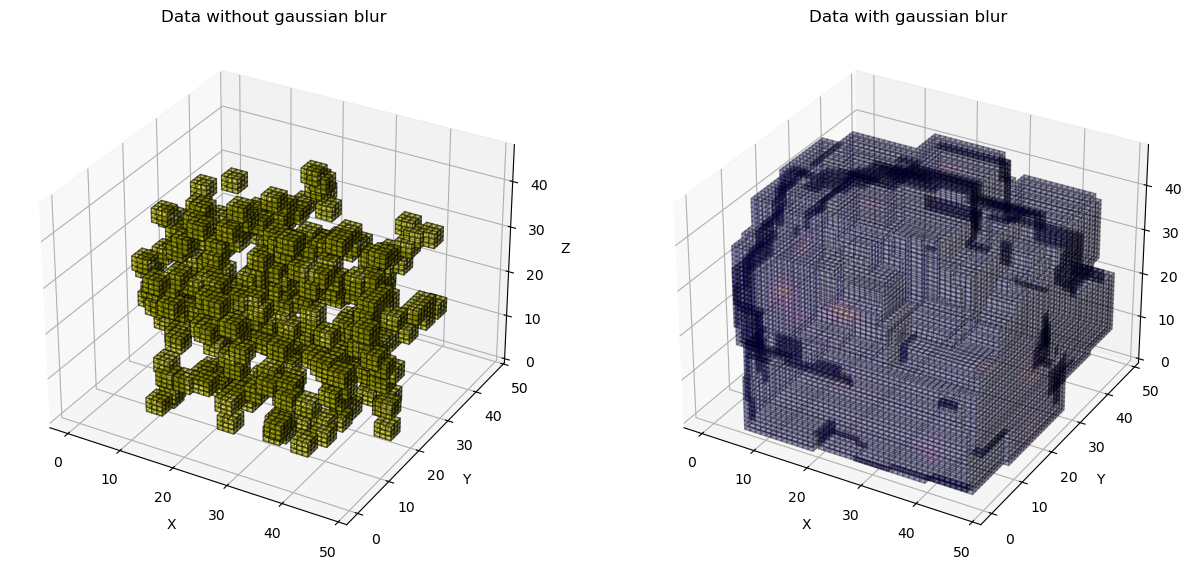

In [12]:
d2 = vol_batch_gaus[0][1].numpy()
d = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.voxels(d,facecolors='yellow', alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Data without gaussian blur')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Data with gaussian blur')

plt.show()

## 3D Quantum filter

Now we visualize an example of a 3D quantum filter, generated from the G3 family of gates. The quantum reservoirs contain 300 gates. Each data sample is separated in blocks of size n=4 and stride 1. We run this example first in the Pytoch backend and then in some Qiskit backends (aer_simulator and fake backend) and compare the execution times.

First we store the unitaries in a file, so that we can use them later.

In [13]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), encoding='frqi', stride=1, backend='torch')

quantum_filters_3D.generate_unitaries(
    gates_name='G3', num_gates=50, num_filters=2, num_features=19,
    save=True, unitaries_file_name='unitaries.pickle'
)

In [14]:
start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus, tol=1e-6)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print('Output shape = ', result.shape)
print(f'Execution time with Pytorch backend: {str(minutes)} mins {str(seconds)} seconds')

/home/kyle/miniforge3/envs/vina_vqe/lib/python3.13/site-packages/ingenii_quantum/hybrid_networks/filters.py:1003: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data) if self.backend=='torch' else np.array(data)


Output shape =  torch.Size([5, 38, 48, 48, 48])
Execution time with Pytorch backend: 0.0 mins 9.0 seconds


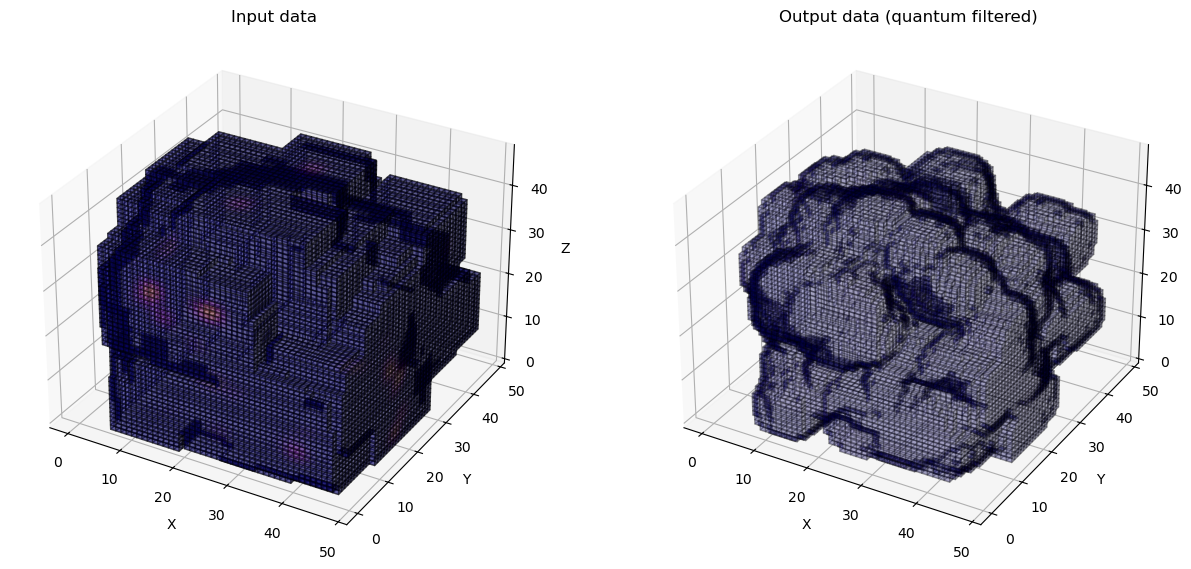

In [15]:
d = vol_batch_gaus[0,1]
d2 = result[0,1]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Running with Qiskit simulator

In [16]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), encoding='frqi', shots=16, backend ='aer_simulator', stride=1)

quantum_filters_3D.generate_qc(
    gates_name='G3',num_gates=50, num_filters=2, num_features=19, save=True,
    saved_gates_filename='gates_list_3D.pickle', saved_qubits_filename='qubits_list_3d.pickle'
)

In [ ]:
# Note: this will take approx. 40 minutes
start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus.numpy().copy(), tol=1e-4)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print('Output shape = ', result.shape)
print(f'Execution time with Qiskit quantum simulation: {str(minutes)} mins {str(seconds)} seconds')

We see that running the code with quantum simulation using Qiskit is much slower than using Pytorch. Also, the results highly depend on the number of shots (the larger the better). With a very small number of shots we see that the outputs are significantly different.

In [ ]:
d = vol_batch_gaus[0,1]
d2 = result[0,1]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Running with Qiskit fake provider

Finally, we can run the code with a fake provider (or actual hardware if you have access to it) using Qiskit. We use bigger (nxn) blocks so that the execution is faster.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
 
# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')
 
# generate a simulator that mimics the real quantum system with the latest calibration results
fake = AerSimulator.from_backend(backend)

In [ ]:
quantum_filters_3D = QuantumFilters3D(shape=(8,8,8), shots=16, backend=fake, stride=2)

# Run to load the quantum circuits
#quantum_filters_3D.load_gates(saved_gates_filename='gates_list_3D.pickle', saved_qubits_filename='qubits_list_3d.pickle')
quantum_filters_3D.generate_qc(gates_name='G3', num_gates=50, num_filters=2, num_features=19, save=False)

In [ ]:
# Note: this will take approx. 2 hours

start_time = time()
result = quantum_filters_3D.get_quantum_filters(vol_batch_gaus[:1,:,:,:,:].numpy().copy(), tol=1e-4)
seconds_taken = time() - start_time
minutes, seconds = round(seconds_taken // 60, 0), round(seconds_taken % 60, 0)
print(f'Execution time with Qiskit fake provider: {str(minutes)} mins {str(seconds)} seconds')

In [ ]:
d = vol_batch_gaus[0, 1]
d2 = result[0, 1]

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d, facecolors=colors, alpha=0.4, edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Input data')

colors = plt.cm.plasma(d2)
ax2.voxels(d2, facecolors=colors, alpha=0.2, edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Output data (quantum filtered)')

plt.show()

## Hybrid neural network: input layer

### 1. Calculate the quantum filters

In [ ]:
# Original data
data = vol_batch_gaus

# Output of the quantum filters
quantum_filters_3D = QuantumFilters3D(shape=(4,4,4), stride=1)
quantum_filters_3D.generate_unitaries(
    gates_name='G3', num_gates=500, num_filters=3, num_features=19, save=False
)
data_QF = quantum_filters_3D.get_quantum_filters(data, tol=1e-6)

### 2. Define the classical CNN that uses both the original data and the quantum filters

In [ ]:
class ModelHybrid1(nn.Module):

    # num_filters=[64,128,256] or [96,128,128]
    def __init__(self, feat_dim=19, num_filters=[57,128,256], use_cuda=True, verbose=False):
        super(ModelHybrid1, self).__init__()
        
        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.verbose = verbose

        self.conv1 = nn.Conv3d(feat_dim, num_filters[0], 7, 1, 3)
        self.bn1 = nn.BatchNorm3d(num_filters[0])
        
        self.conv2 = nn.Conv3d(num_filters[0], self.num_filters[1], 7, 3, 3)
        self.bn2 = nn.BatchNorm3d(self.num_filters[1])
        self.max_pool1 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(self.num_filters[1], self.num_filters[2], 5, 2, 2)
        self.bn3 = nn.BatchNorm3d(self.num_filters[2])
        self.max_pool2 = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(16384, 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()


    def forward(self, x, x_quantum):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        if x_quantum.dim() == 1:
            x_quantum = x_quantum.unsqueeze(-1)
        if self.verbose:
            print('Input', list(x.size()), ' Input quantum', list(x_quantum.size()))
        
        conv1= self.conv1(x)
        if self.verbose:
            print('Conv1 (7x7x7)', list(conv1.shape))

        conv1_res1 = x_quantum + conv1
        if self.verbose:
            print('Conv1 + Quantum', list(conv1_res1.shape))

        conv2 = self.conv2(conv1_res1)
        conv2 = self.bn2(self.relu(conv2))
        if self.verbose:
            print('Conv2 (7x7x7)', list(conv2.shape))
        
        pool1 = self.max_pool1(conv2)
        if self.verbose:
            print('Pooling 1', list(pool1.shape))
            
        conv3 = self.conv3(conv2)
        conv3 = self.bn3(self.relu(conv3))
        if self.verbose:
            print('Conv 3 (7x7x7)',list(conv3.shape))

        pool2 = self.max_pool2(conv3)
        if self.verbose:
            print('Pooling 2', list(pool2.shape))

        flatten = pool2.view(pool2.size(0), -1)
        if self.verbose:
            print('Flatten', list(flatten.shape))

        fc1 = self.fc1(flatten)
        fc1 = self.relu(fc1)
        if self.verbose:
            print('Fc1', list(fc1.shape))

        fc2 = self.fc2(fc1)
        if self.verbose:
            print('Fc2', list(fc2.shape))

        return fc2

In [ ]:
model = ModelHybrid1(use_cuda=False, verbose=True)

In [ ]:
ypred_batch= model(data, data_QF)

## Hybrid neural network: convolutional layer

Instead of using the quantum layer as a pre-processing step, we can use the quantum filter as a layer of the network. For this, we need to use the *QuantumLayer3D* function.

In [ ]:
# Original data (no need to apply the quantum filters now)
data = vol_batch_gaus

In [ ]:
class ModelHybrid2(nn.Module):

    def __init__(self, feat_dim=19, num_filters=[64,64,128], use_cuda=True, verbose=False,
                 shape=(4,4,4), num_filters_q=1, gates_name='G3', num_gates=300, tol=1e-6,stride=2,
                 load_unitaries_file_name=None, unitaries_file_name='unitaries.pickle'):
        super(ModelHybrid2, self).__init__()
        
        self.feat_dim = feat_dim
        self.num_filters = num_filters
        self.use_cuda = use_cuda
        self.verbose = verbose

        self.quantumlayer = QuantumFilters3D(
            shape=shape,stride=stride
        )
        if load_unitaries_file_name:
            self.quantumlayer.load_unitaries(file_name=unitaries_file_name)
        else:
            self.quantumlayer.generate_unitaries(gates_name=gates_name, num_gates=num_gates, num_filters=num_filters_q, num_features=num_filters[0], save=True)
    
        self.conv1 = nn.Conv3d(feat_dim, num_filters[0], 7, 1, 3)
        self.bn1 = nn.BatchNorm3d(num_filters[0])
        
        self.conv2 = nn.Conv3d(num_filters[0], self.num_filters[1], 7, 2, 3)
        self.bn2 = nn.BatchNorm3d(self.num_filters[1])
        self.max_pool1 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(self.num_filters[1], self.num_filters[2], 5, 2, 2)
        self.bn3 = nn.BatchNorm3d(self.num_filters[2])
        self.max_pool2 = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(27648, 10)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()


    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        if self.verbose:
            print('Input', list(x.size()))
        
        conv1 = self.conv1(x)
        conv1 = self.bn1(self.relu(conv1))
        if self.verbose:
            print('Conv1 (7x7x7)', list(conv1.shape))

        conv2 = self.conv2(conv1)
        conv2 = self.bn2(self.relu(conv2))
        if self.verbose:
            print('Conv2 (7x7x7)', list(conv2.shape))
        
        quantum_conv = self.quantumlayer.get_quantum_filters(conv2)     
        if self.verbose:
            print('Quantum filter ', list(quantum_conv.shape))
            
        conv2_quantum = conv2 + quantum_conv
        if self.verbose:
            print('Conv2 + Quantum filter ', list(conv2_quantum.shape))
            
        pool1 = self.max_pool1(conv2_quantum)
        if self.verbose:
            print('Pooling 1', list(pool1.shape))
            
        conv3 = self.conv3(conv2)
        conv3 = self.bn3(self.relu(conv3))
        if self.verbose:
            print('Conv 3 (7x7x7)',list(conv3.shape))

        pool2 = self.max_pool2(conv3)
        if self.verbose:
            print('Pooling 2', list(pool2.shape))

        flatten = pool2.view(pool2.size(0), -1)
        if self.verbose:
            print('Flatten', list(flatten.shape))

        fc1 = self.fc1(flatten)
        fc1 = self.relu(fc1)
        if self.verbose:
            print('Fc1', list(fc1.shape))

        fc2 = self.fc2(fc1)
        if self.verbose:
            print('Fc2', list(fc2.shape))

        return fc2

In [ ]:
model = ModelHybrid2(use_cuda=False, verbose=True, stride=1, shape=(2,2,2))

In [ ]:
ypred_batch = model(data)